In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import psycopg2
import datetime

# Загрузка данных

In [ ]:
df = pd.read_csv('sample_4400000_stratified.csv', sep=';')

In [ ]:
# !!!
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [ ]:
# !!!
df = df.drop('action', axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4384547 entries, 0 to 4384546
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   timestamp  datetime64[ns]
 1   user_id    int64         
 2   post_id    int64         
 3   target     int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 167.3 MB


In [2]:
df_users = pd.read_csv('users.csv', sep=';')
df_posts = pd.read_csv('posts.csv', sep=';')

In [3]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163205 entries, 0 to 163204
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    163205 non-null  int64 
 1   gender     163205 non-null  int64 
 2   age        163205 non-null  int64 
 3   country    163205 non-null  object
 4   city       163205 non-null  object
 5   exp_group  163205 non-null  int64 
 6   os         163205 non-null  object
 7   source     163205 non-null  object
dtypes: int64(4), object(4)
memory usage: 10.0+ MB


In [4]:
df_posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7023 entries, 0 to 7022
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   post_id  7023 non-null   int64 
 1   text     7023 non-null   object
 2   topic    7023 non-null   object
dtypes: int64(1), object(2)
memory usage: 164.7+ KB


## Обработка текста

In [ ]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

1. предобработка текста

In [ ]:
import re
import string

from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer

wnl = WordNetLemmatizer()

def preprocessing(line, token=wnl):
    line = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", ' ', line)
    line = re.sub("(\\n|\\t)", ' ', line)
    line = re.sub("[^a-zA-Z ]", ' ', line)
    line = re.sub("( {2,})", ' ', line)
    line = line.lower()
    line = ' '.join([token.lemmatize(x) for x in line.split(' ')])

    return line


tfidf = TfidfVectorizer(
    stop_words='english',
    preprocessor=preprocessing
)

2. tf-idf постов

In [ ]:
tfidf_data = tfidf.fit_transform(df_posts['text']).toarray()

tfidf_data

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'wa'] not in stop_words.
  % sorted(inconsistent)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
tfidf_data.shape

(7023, 42044)

3. статистика по tf-idf (суммарный, максимальный, средний)

In [ ]:
df_posts['total_tfidf'] = np.sum(tfidf_data, axis=1).reshape(-1,1)
df_posts['max_tfidf'] = np.max(tfidf_data, axis=1).reshape(-1,1)
df_posts['mean_tfidf'] = np.mean(tfidf_data, axis=1).reshape(-1,1)

In [ ]:
df_posts

,post_id,text,topic,total_tfidf,max_tfidf,mean_tfidf
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.451976,0.504114,0.000201
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.514097,0.317233,0.000274
2,3,Asian quake hits European shares\n\nShares in ...,business,12.190354,0.269016,0.000290
3,4,India power shares jump on debut\n\nShares in ...,business,6.416335,0.541172,0.000153
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.205266,0.422695,0.000148
...,...,...,...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie,6.638942,0.259546,0.000158
7019,7316,I give this movie 2 stars purely because of it...,movie,6.471390,0.399528,0.000154
7020,7317,I cant believe this film was allowed to be mad...,movie,5.508128,0.576569,0.000131
7021,7318,The version I saw of this film was the Blockbu...,movie,6.883273,0.231254,0.000164


4. выделение PCA компонент из tf-idf

In [ ]:
from sklearn.decomposition import PCA

centered = tfidf_data - tfidf_data.mean()

pca = PCA(n_components=10)
pca_decomp = pca.fit_transform(centered)

In [ ]:
pca_decomp.shape

(7023, 10)

In [ ]:
pca.singular_values_

array([8.62912658, 7.27603288, 5.7382748 , 5.36985233, 4.8887551 ,
       4.60357341, 4.49890684, 4.17992129, 4.13379694, 3.90511477])

5. выделение кластеров, расстояние до цетров кластеров как признаки постов

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0).fit(pca_decomp)

In [ ]:
dists_columns = [f"dist_{ith}_cluster" for ith in range(1, 11)]

dists_df = pd.DataFrame(
    data=kmeans.transform(pca_decomp),
    columns=dists_columns
)

df_posts = pd.concat((df_posts, dists_df), axis=1)
df_posts.head()

,post_id,text,topic,total_tfidf,max_tfidf,mean_tfidf,dist_1_cluster,dist_2_cluster,dist_3_cluster,dist_4_cluster,dist_5_cluster,dist_6_cluster,dist_7_cluster,dist_8_cluster,dist_9_cluster,dist_10_cluster
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.451976,0.504114,0.000201,0.397028,0.405917,0.373914,0.165309,0.432322,0.529335,0.433145,0.441160,0.360730,0.376792
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.514097,0.317233,0.000274,0.307627,0.310375,0.288459,0.171749,0.343362,0.455302,0.328712,0.179214,0.227525,0.258331
2,3,Asian quake hits European shares\n\nShares in ...,business,12.190354,0.269016,0.000290,0.346309,0.343826,0.328742,0.091940,0.370971,0.483714,0.389056,0.423800,0.283034,0.313915
3,4,India power shares jump on debut\n\nShares in ...,business,6.416335,0.541172,0.000153,0.303374,0.316183,0.313511,0.068549,0.346550,0.415452,0.355034,0.374259,0.235176,0.270557
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.205266,0.422695,0.000148,0.214045,0.225684,0.219969,0.164050,0.264903,0.396555,0.277348,0.319572,0.085800,0.206262


загрузка признакаов в БД

In [ ]:
df_posts.to_sql(    
   "posts_features_0",                    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml",                      
    schema="public",                   
    if_exists='replace'            
   )

загрузак признаков из БД

In [ ]:
df_posts = pd.read_sql(
    """SELECT * FROM public.posts_features_0""",
    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
).drop(['index'], axis=1)

6. объединение признаков постов, текство и пользователей

In [ ]:
df = pd.merge(df,
              df_posts,
              on='post_id',
              how='left')

df.head()

,timestamp,user_id,post_id,target,text,topic,total_tfidf,max_tfidf,mean_tfidf,dist_1_cluster,dist_2_cluster,dist_3_cluster,dist_4_cluster,dist_5_cluster,dist_6_cluster,dist_7_cluster,dist_8_cluster,dist_9_cluster,dist_10_cluster
0,2021-10-02 14:29:21,200,1218,0,Howard hits back at mongrel jibe\n\nMichael Ho...,politics,10.409075,0.454458,0.000248,0.532573,0.552658,0.183318,0.533239,0.500339,0.527206,0.547991,0.642956,0.512737,0.559958
1,2021-11-07 07:43:25,200,1703,0,Bortolami predicts dour contest\n\nItaly skipp...,sport,7.179561,0.418658,0.000171,0.374663,0.386933,0.437049,0.360182,0.301064,0.134458,0.358890,0.502919,0.365542,0.393671
2,2021-11-26 15:53:52,200,1306,0,Hagues six-figure earnings shown\n\nThe reward...,politics,12.039012,0.306142,0.000286,0.298542,0.329150,0.135016,0.294910,0.220656,0.289483,0.305661,0.464334,0.256164,0.294256
3,2021-10-06 15:29:32,200,1226,0,Guantanamo four questioned\n\nThe four Britons...,politics,10.835565,0.288548,0.000258,0.253001,0.328232,0.213029,0.293721,0.206029,0.255931,0.314896,0.461044,0.233351,0.305882
4,2021-12-13 08:19:39,200,3447,0,#NSTworld #NKorea declares emergency over 1st ...,covid,2.658584,0.479620,0.000063,0.330802,0.321223,0.406197,0.290405,0.204422,0.301053,0.118866,0.232267,0.307908,0.356581


In [ ]:
df = pd.merge(df,
              df_users,
              on='user_id',
              how='left')

df.head()

,timestamp,user_id,post_id,target,text,topic,total_tfidf,max_tfidf,mean_tfidf,dist_1_cluster,...,dist_8_cluster,dist_9_cluster,dist_10_cluster,gender,age,country,city,exp_group,os,source
0,2021-10-02 14:29:21,200,1218,0,Howard hits back at mongrel jibe\n\nMichael Ho...,politics,10.409075,0.454458,0.000248,0.532573,...,0.642956,0.512737,0.559958,1,34,Russia,Degtyarsk,3,Android,ads
1,2021-11-07 07:43:25,200,1703,0,Bortolami predicts dour contest\n\nItaly skipp...,sport,7.179561,0.418658,0.000171,0.374663,...,0.502919,0.365542,0.393671,1,34,Russia,Degtyarsk,3,Android,ads
2,2021-11-26 15:53:52,200,1306,0,Hagues six-figure earnings shown\n\nThe reward...,politics,12.039012,0.306142,0.000286,0.298542,...,0.464334,0.256164,0.294256,1,34,Russia,Degtyarsk,3,Android,ads
3,2021-10-06 15:29:32,200,1226,0,Guantanamo four questioned\n\nThe four Britons...,politics,10.835565,0.288548,0.000258,0.253001,...,0.461044,0.233351,0.305882,1,34,Russia,Degtyarsk,3,Android,ads
4,2021-12-13 08:19:39,200,3447,0,#NSTworld #NKorea declares emergency over 1st ...,covid,2.658584,0.479620,0.000063,0.330802,...,0.232267,0.307908,0.356581,1,34,Russia,Degtyarsk,3,Android,ads


7. добавление признаков по времени

In [ ]:
df['hour'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.hour)
df['month'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.month)
df['day'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.dayofweek)

df.head()

,timestamp,user_id,post_id,target,text,topic,total_tfidf,max_tfidf,mean_tfidf,dist_1_cluster,...,gender,age,country,city,exp_group,os,source,hour,month,day
0,2021-10-02 14:29:21,200,1218,0,Howard hits back at mongrel jibe\n\nMichael Ho...,politics,10.409075,0.454458,0.000248,0.532573,...,1,34,Russia,Degtyarsk,3,Android,ads,14,10,5
1,2021-11-07 07:43:25,200,1703,0,Bortolami predicts dour contest\n\nItaly skipp...,sport,7.179561,0.418658,0.000171,0.374663,...,1,34,Russia,Degtyarsk,3,Android,ads,7,11,6
2,2021-11-26 15:53:52,200,1306,0,Hagues six-figure earnings shown\n\nThe reward...,politics,12.039012,0.306142,0.000286,0.298542,...,1,34,Russia,Degtyarsk,3,Android,ads,15,11,4
3,2021-10-06 15:29:32,200,1226,0,Guantanamo four questioned\n\nThe four Britons...,politics,10.835565,0.288548,0.000258,0.253001,...,1,34,Russia,Degtyarsk,3,Android,ads,15,10,2
4,2021-12-13 08:19:39,200,3447,0,#NSTworld #NKorea declares emergency over 1st ...,covid,2.658584,0.479620,0.000063,0.330802,...,1,34,Russia,Degtyarsk,3,Android,ads,8,12,0


In [ ]:
df = df.drop('text', axis=1).set_index('index')

# Catboost

In [ ]:
df_train = df[df.timestamp < '2021-12-15']
df_test = df[df.timestamp >= '2021-12-15']

df_train = df_train.drop('timestamp', axis=1)
df_test = df_test.drop('timestamp', axis=1)

X_train = df_train.drop('target', axis=1)
X_test = df_test.drop('target', axis=1)

y_train = df_train['target']
y_test = df_test['target']

y_train.shape, y_test.shape

((952628,), (189807,))

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

catboost = CatBoostClassifier(iterations=100,
                              learning_rate=1,
                              depth=2)

object_cols = [
    'topic', 'gender', 'country',
    'city', 'exp_group', 'hour', 'month',
    'os', 'source'
]

catboost.fit(X_train, y_train, object_cols)

In [ ]:
print(f"Качество на трейне: {roc_auc_score(y_train, catboost.predict_proba(X_train)[:, 1]):.5f}")
print(f"Качество на тесте: {roc_auc_score(y_test, catboost.predict_proba(X_test)[:, 1]):.5f}")

Качество на трейне: 0.67438
Качество на тесте: 0.64597


вклад признаков:

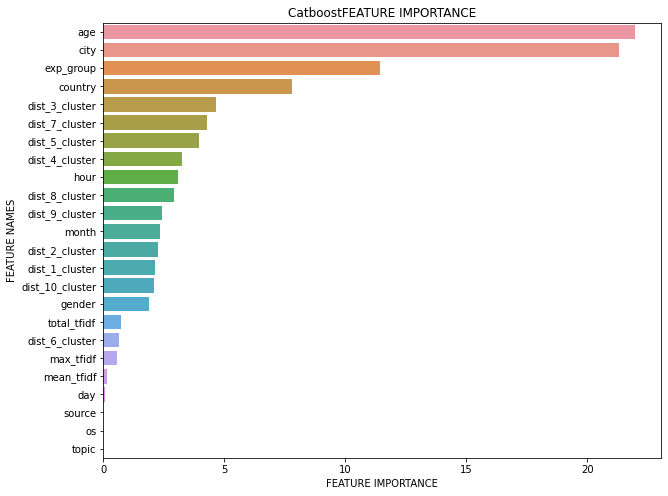

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
plot_feature_importance(catboost.feature_importances_, X_train.columns, 'Catboost')

# Метрики

In [ ]:
users_dsgs = []

X_test_ = X_test.reset_index()
X_test_['pred'] = catboost.predict_proba(X_test)[:, 1]
X_test_['target'] = y_test.values

for user in X_test_['user_id'].unique():
    part = X_test_[X_test_['user_id']==user]
    part = part.sort_values('pred', ascending=False)
    part = part.reset_index()
    user_dsg2 = (part['target'] / np.log2(part.index+2))[:2].sum()

    users_dsgs.append(user_dsg2)
    
print(f"Среднее DSG@2 по пользователям из теста: {np.mean(users_dsgs)}")

Среднее DSG@2 по пользователям из теста: 0.16588077074022498


In [ ]:
users_hit5 = []

for user in tqdm.tqdm_notebook(X_test_['user_id'].unique()):
    part = X_test_[X_test_['user_id']==user]
    part = part.sort_values('pred', ascending=False)
    part = part.reset_index()
    hit_5 = max(1, sum(part['target'][:5]))
    
    users_hit5.append(hit_5)

print(f"Среднее Hitrate@5 по пользователям из теста: {np.mean(users_hit5)}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/90878 [00:00<?, ?it/s]

Среднее Hitrate@5 по пользователям из теста: 1.052796056251238


In [ ]:
catboost.save_model(
    'catboost_model_example',
    format="cbm"                  
)